# Caml API Usage

In [1]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

df_backend = "pandas"

## Create Synthetic Data

In [2]:
from caml.extensions.synthetic_data import make_fully_hetereogenous_dataset

df, true_cates, true_ate = make_fully_hetereogenous_dataset(
    n_obs=1000,
    n_confounders=50,
    ate=17.2,
    seed=None,
)

df["true_cates"] = true_cates
df["uuid"] = df.index

[08/24/24 19:16:28] INFO     Logging has been set up.                                                 ]8;id=253399;file:///home/jakep/projects/caml/caml/logging.py\logging.py]8;;\:]8;id=43151;file:///home/jakep/projects/caml/caml/logging.py#42\42]8;;\

Propensity score is close to 0 or 1. Trimming is at 0.01 and 0.99 is applied


In [3]:
import polars as pl

try:
    from pyspark.sql import SparkSession
except ImportError:
    pass

if df_backend == "polars":
    df = pl.from_pandas(df)
    spark = None
elif df_backend == "pandas":
    spark = None
    pass
elif df_backend == "pyspark":
    spark = (
        SparkSession.builder.master("local[1]")
        .appName("local-tests")
        .config("spark.executor.cores", "1")
        .config("spark.executor.instances", "1")
        .config("spark.sql.shuffle.partitions", "1")
        .getOrCreate()
    )
    df = spark.createDataFrame(df)

In [4]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X45,X46,X47,X48,X49,X50,y,d,true_cates,uuid
0,-0.246181,-1.274200,-0.950982,-0.705522,0.132961,0.814546,1.883581,-0.188843,0.632661,-0.023047,...,-2.612764,0.869625,0.113842,0.095730,0.716684,-0.302220,22.787988,1.0,19.738300,0
1,1.948685,0.261073,-2.629703,0.005834,-0.352464,1.072183,-1.093752,-0.427244,-2.305874,0.670639,...,1.201444,0.412904,-0.120547,-1.460580,0.383900,0.445292,4.540934,0.0,11.616198,1
2,0.615300,1.659502,-0.099698,0.817223,0.106429,0.114220,0.564847,0.073989,-0.303836,1.339558,...,-0.538605,-1.870271,1.196852,-2.239998,0.411400,-1.889548,2.802615,0.0,19.294353,2
3,0.887987,-0.017229,1.593608,0.885682,0.409091,1.043431,0.394262,-1.698353,0.558425,0.933242,...,1.074709,-0.562967,-0.608498,-1.515747,0.491019,-0.125751,26.132472,1.0,24.358482,3
4,-0.457293,-0.296993,-0.979472,0.810209,-1.433864,-1.018180,-0.199094,-0.996772,-0.402186,2.204502,...,-0.121076,0.549883,0.295039,-0.636527,-0.490393,-1.062060,-3.520146,1.0,-6.477713,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.147637,-0.955530,0.393667,-0.281182,0.626307,-0.422972,-2.630214,0.163528,1.020511,-0.364770,...,0.145645,1.335647,-0.485012,0.668727,-1.590170,1.036452,30.132903,1.0,27.992916,995
996,1.310743,1.540612,0.637802,0.060178,0.820293,0.767454,0.222449,-0.112176,-0.966916,0.391996,...,-1.277102,0.842328,0.061312,-0.808946,0.333095,1.076270,2.968386,0.0,31.238688,996
997,-0.552284,0.074332,0.477756,0.984183,-0.469270,-1.480282,1.335541,1.114310,0.860029,0.455822,...,-0.833067,0.136010,1.132567,0.304348,1.735459,0.335995,13.280481,1.0,9.661809,997
998,-0.241476,-0.174939,1.670931,-1.424675,0.311019,1.019852,0.683656,0.478273,0.286818,0.141497,...,0.010682,0.059641,-0.371086,0.713261,-0.126430,0.164833,22.678137,1.0,22.717554,998


## Core API

### CamlCATE

#### Class Instantiation

In [8]:
from caml import CamlCATE

caml = CamlCATE(
    df=df,
    Y="y",
    T="d",
    X=[c for c in df.columns if "X" in c],
    W=[c for c in df.columns if "W" in c],
    uuid="uuid",
    discrete_treatment=True,
    discrete_outcome=False,
    seed=0,
)

#### Nuissance Function AutoML

In [9]:
caml.auto_nuisance_functions(
    flaml_Y_kwargs={"time_budget": 30},
    flaml_T_kwargs={"time_budget": 30},
    use_ray=False,
    use_spark=False,
)

[flaml.automl.logger: 08-24 19:16:52] {1680} INFO - task = regression
[flaml.automl.logger: 08-24 19:16:52] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 08-24 19:16:52] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 08-24 19:16:52] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 08-24 19:16:52] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-24 19:16:52] {2345} INFO - Estimated sufficient time budget=2923s. Estimated necessary time budget=21s.
[flaml.automl.logger: 08-24 19:16:52] {2392} INFO -  at 0.3s,	estimator lgbm's best error=187.9247,	best estimator lgbm's best error=187.9247
[flaml.automl.logger: 08-24 19:16:52] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-24 19:16:53] {2392} INFO -  at 0.8s,	estimator lgbm's best error=187.9247,	best estimator lgbm's best error=187.9247
[flaml.automl.logger: 08-24 19:16:53] {2219} 

#### Fit and ensemble CATE models

In [10]:
caml.fit_validator(
    subset_cate_models=[
        "LinearDML",
        "NonParamDML",
        "DML-Lasso3d",
        "CausalForestDML",
        "XLearner",
        "DomainAdaptationLearner",
        "SLearner",
        "TLearner",
        "DRLearner",
    ],
    rscorer_kwargs={},
    use_ray=True,
    ray_remote_func_options_kwargs={},
)

2024-08-24 19:18:23,636	INFO worker.py:1772 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(fit_model pid=544311) The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


[08/24/24 19:20:22] INFO     Ensemble Estimator RScore: 0.87284513990122                                ]8;id=223841;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=621210;file:///home/jakep/projects/caml/caml/core/cate.py#849\849]8;;\

                    INFO     Inidividual Estimator RScores: {'LinearDML': 0.8540660306283655,           ]8;id=408668;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=308437;file:///home/jakep/projects/caml/caml/core/cate.py#850\850]8;;\
                             'NonParamDML': 0.8670505743586602, 'DML-Lasso3d': 0.8302071071188233,                 
                             'CausalForestDML': 0.8518549197584651, 'XLearner': 0.8706935718630026,                
                             'DomainAdaptationLearner': 0.8712209354522116, 'SLearner':                            
                             0.8732171083130185, 'TLearner': 0.871951430965139, 'DRLearner':                       
                             0.8695611614338807}                                                                   

                    INFO     The best estimator is greater than the ensemble estimator. Returning that  ]8;id=181828;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=733904;file:///home/jakep/projects/caml/caml/core/cate.py#859\859]8;;\
                             individual estimator.                                                                 

In [11]:
caml.validation_estimator

                    INFO     The validation estimator has been fit and will be returned.                ]8;id=241962;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=914494;file:///home/jakep/projects/caml/caml/core/_base.py#32\32]8;;\

#### CATE Validation

[08/24/24 19:20:25] INFO     All validation results suggest that the model has found statistically      ]8;id=340941;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=861175;file:///home/jakep/projects/caml/caml/core/cate.py#396\396]8;;\
                             significant heterogeneity.                                                            

   treatment  blp_est  blp_se  blp_pval  qini_est  qini_se  qini_pval  autoc_est  autoc_se  autoc_pval  cal_r_squared
0          1    1.007    0.01       0.0     4.777    0.363        0.0     12.565     1.055         0.0          0.978


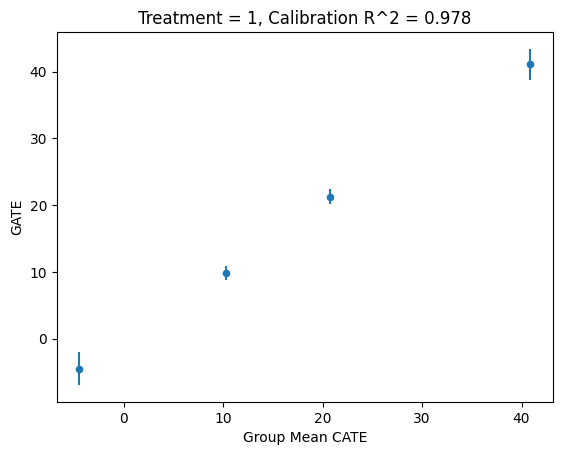

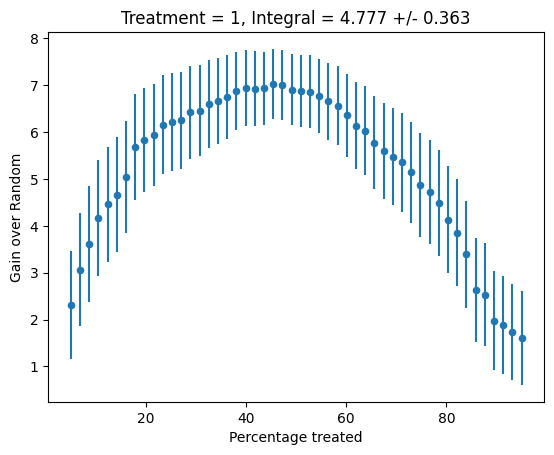

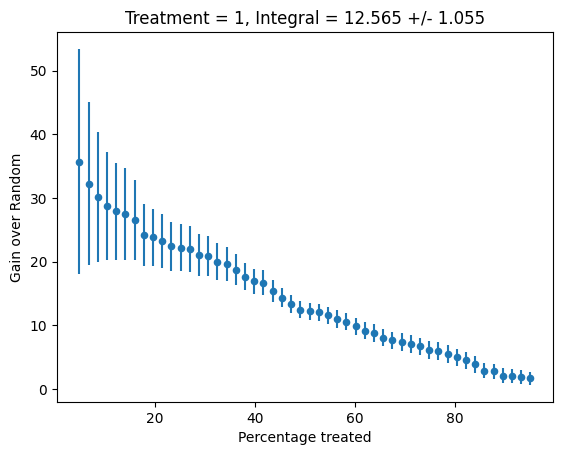

In [12]:
validation_results = caml.validate(estimator=None, print_full_report=True)

#### Refit best estimator on full dataset

In [13]:
caml.fit_final()

In [14]:
caml.final_estimator

                    INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=276796;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=916541;file:///home/jakep/projects/caml/caml/core/_base.py#42\42]8;;\
                             returned.                                                                             

#### Predict CATEs

In [15]:
## "Out of sample" predictions

df_predictions = caml.predict(
    out_of_sample_df=df,
    out_of_sample_uuid="uuid",
    return_predictions=False,
    join_predictions=True,
)

if df_backend == "pyspark":
    df_predictions.show()
else:
    print(df_predictions)

           X1        X2        X3        X4        X5        X6        X7  \
0   -0.246181 -1.274200 -0.950982 -0.705522  0.132961  0.814546  1.883581   
1    1.948685  0.261073 -2.629703  0.005834 -0.352464  1.072183 -1.093752   
2    0.615300  1.659502 -0.099698  0.817223  0.106429  0.114220  0.564847   
3    0.887987 -0.017229  1.593608  0.885682  0.409091  1.043431  0.394262   
4   -0.457293 -0.296993 -0.979472  0.810209 -1.433864 -1.018180 -0.199094   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.147637 -0.955530  0.393667 -0.281182  0.626307 -0.422972 -2.630214   
996  1.310743  1.540612  0.637802  0.060178  0.820293  0.767454  0.222449   
997 -0.552284  0.074332  0.477756  0.984183 -0.469270 -1.480282  1.335541   
998 -0.241476 -0.174939  1.670931 -1.424675  0.311019  1.019852  0.683656   
999  1.204780 -0.018272  0.642867 -1.025366  1.644496 -0.102401  1.113809   

           X8        X9       X10  ...       X46       X47       X48  \
0  

In [16]:
## Append to internal dataframe

caml.predict(
    out_of_sample_df=None,
    out_of_sample_uuid=None,
    join_predictions=True,
    return_predictions=False,
)

caml.dataframe

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X46,X47,X48,X49,X50,y,d,true_cates,uuid,cate_predictions
0,-0.246181,-1.274200,-0.950982,-0.705522,0.132961,0.814546,1.883581,-0.188843,0.632661,-0.023047,...,0.869625,0.113842,0.095730,0.716684,-0.302220,22.787988,1.0,19.738300,0,20.160495
1,1.948685,0.261073,-2.629703,0.005834,-0.352464,1.072183,-1.093752,-0.427244,-2.305874,0.670639,...,0.412904,-0.120547,-1.460580,0.383900,0.445292,4.540934,0.0,11.616198,1,9.236186
2,0.615300,1.659502,-0.099698,0.817223,0.106429,0.114220,0.564847,0.073989,-0.303836,1.339558,...,-1.870271,1.196852,-2.239998,0.411400,-1.889548,2.802615,0.0,19.294353,2,18.794950
3,0.887987,-0.017229,1.593608,0.885682,0.409091,1.043431,0.394262,-1.698353,0.558425,0.933242,...,-0.562967,-0.608498,-1.515747,0.491019,-0.125751,26.132472,1.0,24.358482,3,23.444381
4,-0.457293,-0.296993,-0.979472,0.810209,-1.433864,-1.018180,-0.199094,-0.996772,-0.402186,2.204502,...,0.549883,0.295039,-0.636527,-0.490393,-1.062060,-3.520146,1.0,-6.477713,4,-5.465768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.147637,-0.955530,0.393667,-0.281182,0.626307,-0.422972,-2.630214,0.163528,1.020511,-0.364770,...,1.335647,-0.485012,0.668727,-1.590170,1.036452,30.132903,1.0,27.992916,995,27.745743
996,1.310743,1.540612,0.637802,0.060178,0.820293,0.767454,0.222449,-0.112176,-0.966916,0.391996,...,0.842328,0.061312,-0.808946,0.333095,1.076270,2.968386,0.0,31.238688,996,30.529176
997,-0.552284,0.074332,0.477756,0.984183,-0.469270,-1.480282,1.335541,1.114310,0.860029,0.455822,...,0.136010,1.132567,0.304348,1.735459,0.335995,13.280481,1.0,9.661809,997,10.275403
998,-0.241476,-0.174939,1.670931,-1.424675,0.311019,1.019852,0.683656,0.478273,0.286818,0.141497,...,0.059641,-0.371086,0.713261,-0.126430,0.164833,22.678137,1.0,22.717554,998,21.935939


#### CATE Rank Ordering

In [17]:
## "Out of sample" predictions

df_rank_ordered = caml.rank_order(
    out_of_sample_df=df_predictions, return_rank_order=False, join_rank_order=True
)

df_rank_ordered

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X47,X48,X49,X50,y,d,true_cates,uuid,cate_predictions,cate_ranking
0,0.098873,-2.047471,-0.919803,0.566395,2.857811,0.673014,-0.801269,-1.018265,1.751302,1.135212,...,0.036920,-0.461712,0.006068,0.255008,65.924937,1.0,65.330278,277,63.617159,0
1,0.000555,0.087877,0.346426,-0.691883,3.506982,0.129047,0.546016,-0.178966,0.632143,0.384579,...,-1.872701,-0.473291,1.284942,0.050942,2.401395,0.0,76.192159,196,60.421574,1
2,-1.135132,0.306710,-0.735048,-0.040662,2.721447,0.029122,-0.818205,1.717546,0.736462,-0.617422,...,1.488313,-1.017432,0.965691,0.276485,62.921279,1.0,63.048645,268,59.827181,2
3,0.419552,1.498328,-0.001713,-0.477370,2.498186,-0.771486,-0.507519,-0.954831,-0.606199,-1.123812,...,0.639620,-0.315770,-1.615912,-0.327509,62.379173,1.0,59.313053,429,58.935331,3
4,1.037186,-0.026512,-1.291829,-1.071286,2.573731,-0.042306,-1.802170,-1.649797,-0.169826,-0.715459,...,-0.118501,0.805946,0.935876,0.432677,61.545043,1.0,60.577071,815,58.648805,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.100824,0.315690,-0.673006,0.699648,-2.397660,1.625240,1.397913,0.642165,0.703181,0.408108,...,-0.288494,1.224889,0.987245,1.338624,-18.309803,1.0,-22.603876,791,-22.041368,995
996,-0.752559,1.092341,-0.421944,0.147824,-2.481522,1.291770,-1.357008,1.566003,-1.014990,1.185446,...,-0.404063,0.317593,1.428591,-1.279750,-20.906900,1.0,-24.007043,528,-22.153801,996
997,1.973172,1.723508,1.155148,-1.562033,-2.345816,-0.795644,-0.147862,0.401086,-1.754101,0.257217,...,0.595469,-0.195044,-0.002387,0.143260,4.570123,0.0,-21.736413,382,-23.204234,997
998,-0.032742,-2.454188,-0.604648,-0.354949,-2.712966,0.827282,-0.779570,0.714476,-0.572021,-1.442043,...,-0.236065,0.865011,3.110486,1.306388,-26.432933,1.0,-27.879548,624,-23.610627,998


In [18]:
## Append to internal dataframe

caml.rank_order(out_of_sample_df=None, return_rank_order=False, join_rank_order=True)

caml.dataframe

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X47,X48,X49,X50,y,d,true_cates,uuid,cate_predictions,cate_ranking
0,0.098873,-2.047471,-0.919803,0.566395,2.857811,0.673014,-0.801269,-1.018265,1.751302,1.135212,...,0.036920,-0.461712,0.006068,0.255008,65.924937,1.0,65.330278,277,63.617159,0
1,0.000555,0.087877,0.346426,-0.691883,3.506982,0.129047,0.546016,-0.178966,0.632143,0.384579,...,-1.872701,-0.473291,1.284942,0.050942,2.401395,0.0,76.192159,196,60.421574,1
2,-1.135132,0.306710,-0.735048,-0.040662,2.721447,0.029122,-0.818205,1.717546,0.736462,-0.617422,...,1.488313,-1.017432,0.965691,0.276485,62.921279,1.0,63.048645,268,59.827181,2
3,0.419552,1.498328,-0.001713,-0.477370,2.498186,-0.771486,-0.507519,-0.954831,-0.606199,-1.123812,...,0.639620,-0.315770,-1.615912,-0.327509,62.379173,1.0,59.313053,429,58.935331,3
4,1.037186,-0.026512,-1.291829,-1.071286,2.573731,-0.042306,-1.802170,-1.649797,-0.169826,-0.715459,...,-0.118501,0.805946,0.935876,0.432677,61.545043,1.0,60.577071,815,58.648805,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.100824,0.315690,-0.673006,0.699648,-2.397660,1.625240,1.397913,0.642165,0.703181,0.408108,...,-0.288494,1.224889,0.987245,1.338624,-18.309803,1.0,-22.603876,791,-22.041368,995
996,-0.752559,1.092341,-0.421944,0.147824,-2.481522,1.291770,-1.357008,1.566003,-1.014990,1.185446,...,-0.404063,0.317593,1.428591,-1.279750,-20.906900,1.0,-24.007043,528,-22.153801,996
997,1.973172,1.723508,1.155148,-1.562033,-2.345816,-0.795644,-0.147862,0.401086,-1.754101,0.257217,...,0.595469,-0.195044,-0.002387,0.143260,4.570123,0.0,-21.736413,382,-23.204234,997
998,-0.032742,-2.454188,-0.604648,-0.354949,-2.712966,0.827282,-0.779570,0.714476,-0.572021,-1.442043,...,-0.236065,0.865011,3.110486,1.306388,-26.432933,1.0,-27.879548,624,-23.610627,998


#### CATE Visualization/Summary

In [19]:
cate_summary = caml.summarize(out_of_sample_df=df_rank_ordered)

cate_summary

,cate_mean,cate_sum,cate_std,cate_min,cate_max,count
0,16.923216,16923.216395,17.060288,-29.255976,63.617159,1000


In [20]:
cate_summary = caml.summarize(out_of_sample_df=None)

cate_summary

,cate_mean,cate_sum,cate_std,cate_min,cate_max,count
0,16.923216,16923.216395,17.060288,-29.255976,63.617159,1000


#### Access my dataframe and estimator object 

In [21]:
caml.dataframe

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X47,X48,X49,X50,y,d,true_cates,uuid,cate_predictions,cate_ranking
0,0.098873,-2.047471,-0.919803,0.566395,2.857811,0.673014,-0.801269,-1.018265,1.751302,1.135212,...,0.036920,-0.461712,0.006068,0.255008,65.924937,1.0,65.330278,277,63.617159,0
1,0.000555,0.087877,0.346426,-0.691883,3.506982,0.129047,0.546016,-0.178966,0.632143,0.384579,...,-1.872701,-0.473291,1.284942,0.050942,2.401395,0.0,76.192159,196,60.421574,1
2,-1.135132,0.306710,-0.735048,-0.040662,2.721447,0.029122,-0.818205,1.717546,0.736462,-0.617422,...,1.488313,-1.017432,0.965691,0.276485,62.921279,1.0,63.048645,268,59.827181,2
3,0.419552,1.498328,-0.001713,-0.477370,2.498186,-0.771486,-0.507519,-0.954831,-0.606199,-1.123812,...,0.639620,-0.315770,-1.615912,-0.327509,62.379173,1.0,59.313053,429,58.935331,3
4,1.037186,-0.026512,-1.291829,-1.071286,2.573731,-0.042306,-1.802170,-1.649797,-0.169826,-0.715459,...,-0.118501,0.805946,0.935876,0.432677,61.545043,1.0,60.577071,815,58.648805,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.100824,0.315690,-0.673006,0.699648,-2.397660,1.625240,1.397913,0.642165,0.703181,0.408108,...,-0.288494,1.224889,0.987245,1.338624,-18.309803,1.0,-22.603876,791,-22.041368,995
996,-0.752559,1.092341,-0.421944,0.147824,-2.481522,1.291770,-1.357008,1.566003,-1.014990,1.185446,...,-0.404063,0.317593,1.428591,-1.279750,-20.906900,1.0,-24.007043,528,-22.153801,996
997,1.973172,1.723508,1.155148,-1.562033,-2.345816,-0.795644,-0.147862,0.401086,-1.754101,0.257217,...,0.595469,-0.195044,-0.002387,0.143260,4.570123,0.0,-21.736413,382,-23.204234,997
998,-0.032742,-2.454188,-0.604648,-0.354949,-2.712966,0.827282,-0.779570,0.714476,-0.572021,-1.442043,...,-0.236065,0.865011,3.110486,1.306388,-26.432933,1.0,-27.879548,624,-23.610627,998


In [22]:
from econml.score import EnsembleCateEstimator

# Use this estimator object as pickled object for optimized inference
final_estimator = caml.final_estimator

if isinstance(final_estimator, EnsembleCateEstimator):
    for model in final_estimator._cate_models:
        print(model)
        print(model._input_names)
else:
    print(final_estimator)
    print(final_estimator._input_names)

                    INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=843398;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=493535;file:///home/jakep/projects/caml/caml/core/_base.py#42\42]8;;\
                             returned.                                                                             

{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49'], 'output_names': ['Y0'], 'treatment_names': ['T0_1.0']}
